<font size = 7><h1 align = center>Analysis</h1 ></font>      

In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from GalPop import *
from tqdm.notebook import tqdm
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)

In [2]:
### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = np.arange(2.0, 5.5, 0.5)

pk_path = "HyperionPeaks/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]


cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

---
---
---


<font size = 5><h1 align = center>Prep Subpopulations</h1 ></font>      

First, load in the files and make subpopulations. The subpopulations are:
- 'field1'/'field2' ---> The lower and upper redshift fields
- 'field' ---> The combined field sample
- 'h{sig}' for some {sig} ---> The Hyperion members at or above that threshold

We also impose a magnitude cut in this step

In [3]:
# gp_folder = "LP_GalPops/"

# tot_pops = [GalPop.loadFile(gp_folder + f) for f in sorted(os.listdir(gp_folder))]


# for i, t in tqdm(enumerate(tot_pops), total=len(tot_pops)):

#     # Reset variables
#     t.subpops = {}
#     t.vols = {}

#     t.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)
#     t.subPop("field2", [-99, 4.0], 13. , [2.8, 2.9], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)

#     t.subpops['field'] = np.logical_or(t.subpops['field1'], t.subpops['field2'])


#     # make a Hyperion pop
#     t.subPop('h2.0', [2.0, np.inf], 13., [2.35, 2.7], pk_path, 'peaks_sig2.0.dat', sig_cube, pk_nums=[1])


#     # Make other hyperion pops
#     for si, sigma in enumerate(sigs[1:]):
#         t.subPop(f"h{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube)
#         t.subpops[f'h{sigma}'] = np.logical_and(t.subpops[f'h{sigma}'], t.subpops['h2.0'])

#     t.saveFile(f"LP_GalPops3/MC_{i}.npy")

In [5]:
gp_folder = "LP_GalPops/"

tot_pops = [GalPop.loadFile(gp_folder + f) for f in sorted(os.listdir(gp_folder))]

for t in tqdm(tot_pops):

    # Reset variables
    t.subpops = {}
    t.vols = {}

    # Make a magntiude cut and check mass
    bad = np.where((t.mags['IRAC'] >25.0) | (t.ms < 9.5))
    # bad = np.where((t.mags['IRAC'] >25.0))
    t.del_objs(t.IDs[bad])

    t.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)
    t.subPop("field2", [-99, 4.0], 13. , [2.8, 2.9], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)

    # Combine into a field pop
    t.subpops['field'] = np.logical_or(t.subpops['field1'], t.subpops['field2'])


    # make a Hyperion pop
    t.subPop('h2.0', [2.0, np.inf], 13., [2.35, 2.7], pk_path, 'peaks_sig2.0.dat', sig_cube, pk_nums=[1])

    # Find which objects are either field or Hyperion and keep only those
    no_use = np.logical_not(np.logical_or(t.subpops['field'],t.subpops['h2.0']))
    t.del_objs(t.IDs[no_use])


    # Make other hyperion pops
    for si, sigma in enumerate(sigs[1:]):
        t.subPop(f"h{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si+1], sig_cube)



  0%|          | 0/100 [00:00<?, ?it/s]

We can plot an MC iteration if need be

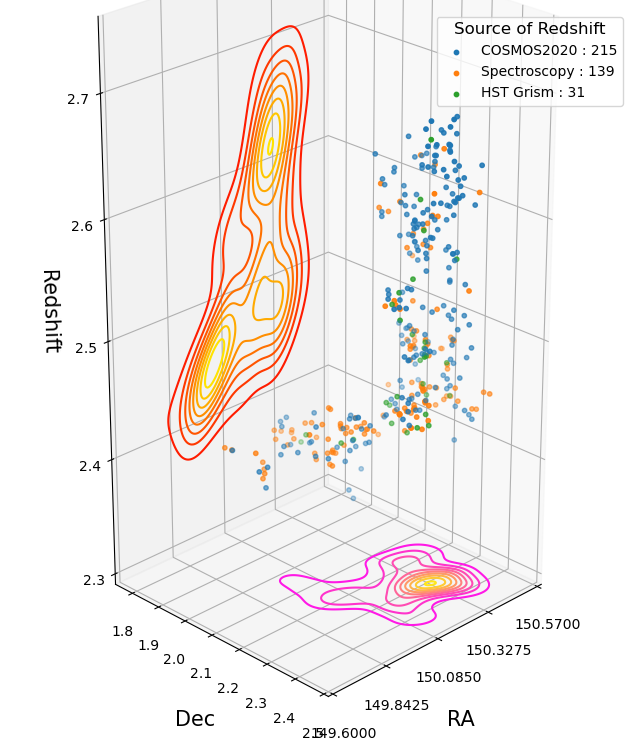

In [5]:
xs = (149.6, 150.57)
ys = (1.75, 2.5)
zs = (2.3, 2.75)

tot_pops[1].popPlot2('h2.0',xs, ys, zs, 45, 25 )

----
----
----
----


<font size = 5><h1 align = center>Find Quiescent Galaxies</h1 ></font>      

In [42]:
for t in tot_pops:
    
    ssfrs = t.SFRs - t.ms

    qg = np.where(ssfrs <= -10.35)
    sf = np.where(ssfrs > -10.35)

    t.misc['Qs'] = np.isin(range(len(t.IDs)), qg)
    t.misc['SFs'] = np.isin(range(len(t.IDs)), sf)

Let's figure out which galaxies in a given population are quenched given a few metrics

In [7]:
def fit_CC(x_mags, y_mags, x_lim, y_lim, A0, zp0):

    def l1(x, A,zp): return -x/A + y_lim + (y_lim-zp)/A**2
    def l2(x, A, zp): return -x/A + x_lim/A + A*x_lim + zp
    def dl(x, A, zp): return A*x + zp
    
    sub_gals = np.where((y_mags >= l1(x_mags, A0, zp0)) & (y_mags <= l2(x_mags, A0, zp0)) )

    xs, ys = x_mags[sub_gals], y_mags[sub_gals]
    z = zp0*np.ones(len(xs))
    A = A0

    dist = (z + A*xs - ys) / np.sqrt(1+A**2)
    plt.hist(dist, bins=50)
    plt.show()
    return sub_gals

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_color_color_histogram(x_Q, y_Q, x_SF, y_SF, diagram="UVJ", population="both", t=''):
    """
    Plots a 2D histogram of quiescent and/or star-forming galaxies in UVJ or NUVrJ color space.
    
    Parameters:
    - x_Q: x-axis colors for quiescent galaxies (V-J or r-J)
    - y_Q: y-axis colors for quiescent galaxies (U-V or NUV-r)
    - x_SF: x-axis colors for star-forming galaxies (V-J or r-J)
    - y_SF: y-axis colors for star-forming galaxies (U-V or NUV-r)
    - diagram: Choose between 'UVJ' or 'NUVrJ' color-color diagram
    - population: Choose which population to plot ('Q', 'SF', or 'both')
    """
    # Define limits and lines for UVJ and NUVrJ diagrams
    if diagram == "UVJ":
        A, zp = 0.88, 0.59
        xmin, xmax = -1, 2.2
        ymin, ymax = 0, 2.4
        x_label = r"$\rm (V-J)_0$"
        y_label = r"$\rm (U-V)_0$"
        
        # Separation lines for UVJ
        x_lim, y_lim = 1.4, 1.2
        UV_min = A * x_lim + zp
        VJ_max = (y_lim - zp) / A
        h_line_x = np.linspace(xmin, VJ_max, 10)
        h_line_y = [y_lim] * 10
        v_line_x = [x_lim] * 10
        v_line_y = np.linspace(ymax, UV_min, 10)
        d_line_x = np.linspace(VJ_max, x_lim, 10)
        d_line_y = A * d_line_x + zp

    elif diagram == "NUVrJ":
        A, zp = 3, 1

        xmin, xmax = -1, 2
        ymin, ymax = 0, 6
        x_label = r"$\rm (r-J)_0$"
        y_label = r"$\rm (NUV-r)_0$"
        
        # Separation lines for UVJ
        y_lim = 3.1
        rJ_max = (y_lim - zp) / A
        h_line_x = np.linspace(xmin, rJ_max, 10)
        h_line_y = [y_lim] * 10
        d_line_x = np.linspace(rJ_max, ymax, 10)
        d_line_y = A * d_line_x + zp

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Define bins for the 2D histograms
    xbs = np.linspace(xmin, xmax, 35)
    ybs = np.linspace(ymin, ymax, 35)

    # Plot quiescent galaxies if selected
    if population in ["Q", "both"]:
        hist_Q, xedges_Q, yedges_Q, im_Q = ax.hist2d(x_Q, y_Q, bins=(xbs, ybs), cmap='Reds', norm=LogNorm(), alpha=0.5)
        cbar_Q = plt.colorbar(im_Q, ax=ax, label='Number of Quiescent Galaxies', pad=0.01)

    # Plot star-forming galaxies if selected
    if population in ["SF", "both"]:
        hist_SF, xedges_SF, yedges_SF, im_SF = ax.hist2d(x_SF, y_SF, bins=(xbs, ybs), cmap='Blues', norm=LogNorm(), alpha=0.5)
        cbar_SF = plt.colorbar(im_SF, ax=ax, label='Number of Star-forming Galaxies', pad=0.01)

    # Set the plot limits and labels
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), xlabel=x_label, ylabel=y_label,
           title=t)

    # Plot the separation lines
    if diagram == "UVJ":
        ax.plot(h_line_x, h_line_y, color='black')
        ax.plot(v_line_x, v_line_y, color='black')
        ax.plot(d_line_x, d_line_y, color='black')
    elif diagram == "NUVrJ":
        ax.plot(h_line_x, h_line_y, color='black')
        ax.plot(d_line_x, d_line_y, color='black')

    # Show the plot
    plt.show()


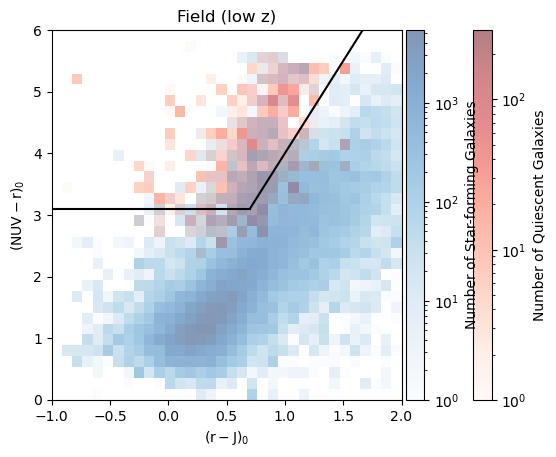

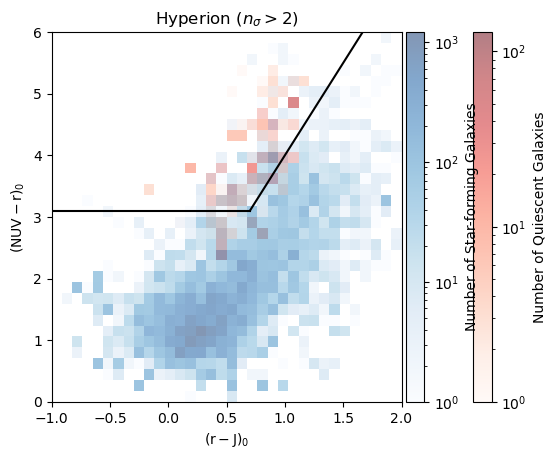

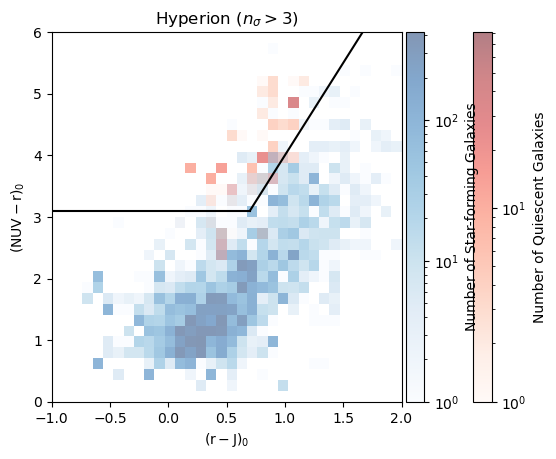

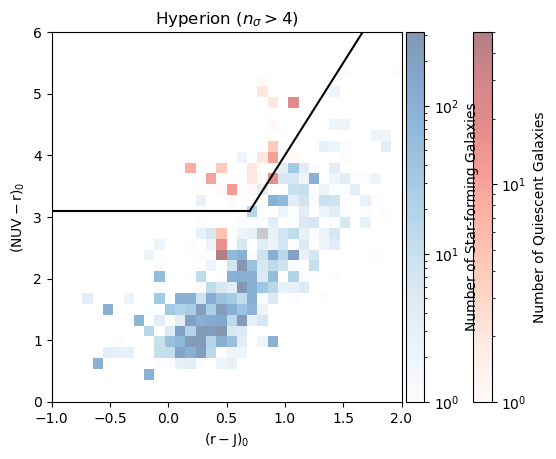

In [45]:
titles = ['Field (low z)', 'Hyperion ($n_\sigma > 2$)', 'Hyperion ($n_\sigma > 3$)', 'Hyperion ($n_\sigma > 4$)']

for sp, til in zip(['field1', 'h2.0', 'h3.0', 'h4.0'], titles):
    tot_abs_Q = [[] for ki in tot_pops[0].mags]
    tot_abs_SF = [[] for ki in tot_pops[0].mags]

    for t in tot_pops:


        qi = np.where(t.subpops[sp] & (t.misc['Qs']==True))
        sfi = np.where(t.subpops[sp] &  (t.misc['SFs'] == True))

        # gi = np.where(t.subpops['h2.0'] & (t.ms >= 9.5))

        # gi = np.where(np.logical_or(t.subpops['h2.0'], t.subpops['field']) & (t.ms >= 9.5))

        # g_i = np.where((t.ms[gi] >= 9.5))

        for ki, k in enumerate(t.mags):
            tot_abs_Q[ki].append(t.mags[k][qi])
            tot_abs_SF[ki].append(t.mags[k][sfi])


    tot_abs_Q = np.array([np.concatenate(Mags) for Mags in tot_abs_Q])
    tot_abs_SF = np.array([np.concatenate(Mags) for Mags in tot_abs_SF])

    ### NUVrJ

    x_q = tot_abs_Q[2] - tot_abs_Q[4]
    y_q = tot_abs_Q[0] - tot_abs_Q[2]

    x_sf = tot_abs_SF[2] - tot_abs_SF[4]
    y_sf = tot_abs_SF[0] - tot_abs_SF[2]

    # x_q = tot_abs_Q[3] - tot_abs_Q[4]
    # y_q = tot_abs_Q[1] - tot_abs_Q[3]

    # x_sf = tot_abs_SF[3] - tot_abs_SF[4]
    # y_sf = tot_abs_SF[1] - tot_abs_SF[3]



    plot_color_color_histogram(x_q, y_q, x_sf, y_sf, diagram='NUVrJ', population="both", t=til)

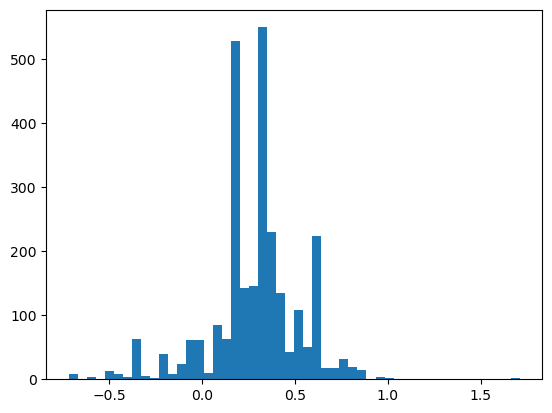

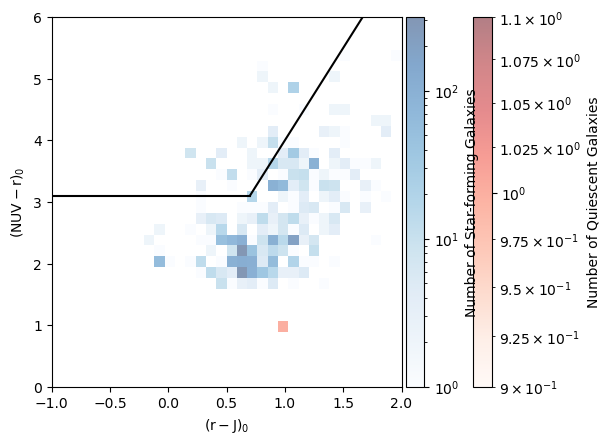

In [47]:
sg = fit_CC(np.concatenate((x_q, x_sf)), np.concatenate((y_q, y_sf)), 3.1, 1.8, 3, 1)

x = np.concatenate((x_q, x_sf))[sg]
y = np.concatenate((y_q, y_sf))[sg]

plot_color_color_histogram([1], [1], x, y, 'NUVrJ', 'both')

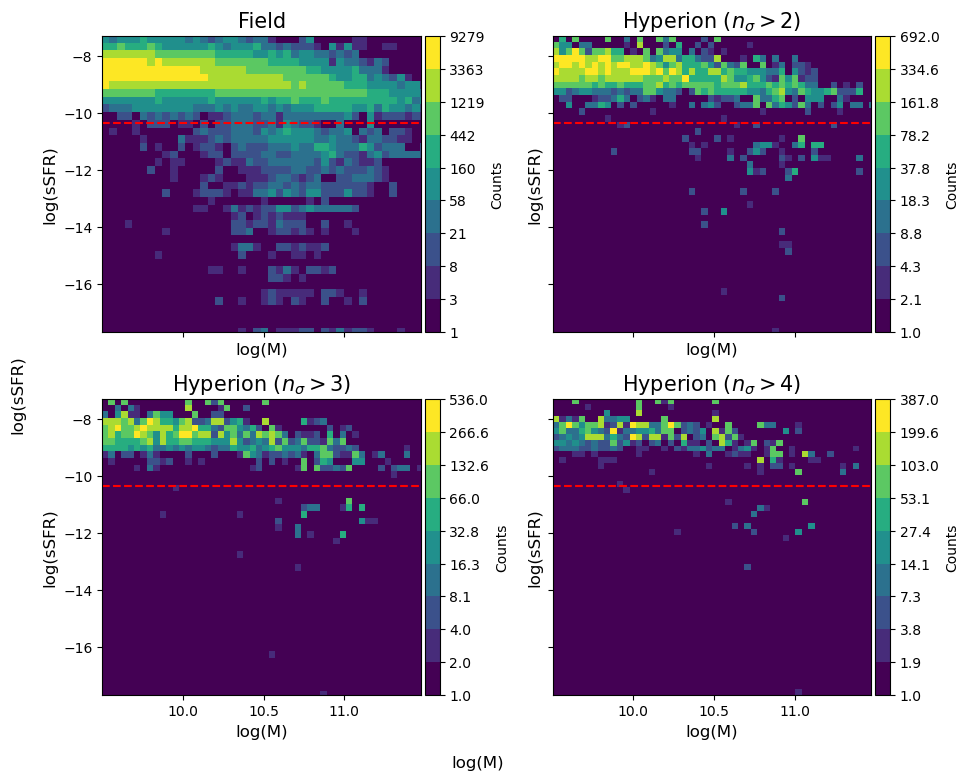

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_2d_histogram(x, y, x_bins, y_bins, title, xlabel, ylabel, hl, ax=None):
    """
    Plots a 2D histogram with logarithmic color scaling.

    Parameters:
    - x: Data for the x-axis
    - y: Data for the y-axis
    - x_bins: Number of bins for the x-axis
    - y_bins: Number of bins for the y-axis
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    - hl: Horizontal line position on the y-axis
    - ax: Matplotlib axis object where the plot will be drawn
    """
    # Create the 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

    # If no axis is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots()

    # Use a logarithmic norm, but with discrete levels
    levels = np.logspace(0, np.log10(np.max(hist)), num=10)
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

    # Plot the 2D histogram with a discrete log-scale colorbar
    img = ax.imshow(hist.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    norm=norm, cmap='viridis')

    # Add a colorbar with discrete log-scale levels
    cbar = plt.colorbar(img, ax=ax, ticks=levels, pad=0.01)
    cbar.set_label('Counts')

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=15)
    ax.axhline(hl, c='red', ls='--')

# Example of usage in a 2x2 grid
sps = ['field', 'h2.0', 'h3.0', 'h4.0']
titles = ['Field', 'Hyperion ($n_\sigma > 2$)', 'Hyperion ($n_\sigma > 3$)', 'Hyperion ($n_\sigma > 4$)']

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, title, sp in zip(axes, titles, sps):
    sfrs = []
    ssfrs = []
    ms = []
    ages = []

    for t in tot_pops:
        sfrs.append(t.SFRs[t.subpops[sp]])
        ms.append(t.ms[t.subpops[sp]])
        ssfrs.append(t.SFRs[t.subpops[sp]] - t.ms[t.subpops[sp]])
        ages.append(t.misc['Age'][t.subpops[sp]])

    sfrs = np.concatenate(sfrs)
    ssfrs = np.concatenate(ssfrs)
    ms = np.concatenate(ms)
    ages = np.concatenate(ages)

    plot_2d_histogram(ms, ssfrs, 50, 50, title, 'log(M)', 'log(sSFR)', -10.35, ax=ax)

fig.text(0.5, 0.04, 'log(M)', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, 'log(sSFR)', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()
